### Cab-Driver Agent

In [1]:
import collections
import numpy as np
import random
import pickle
import time
import os

from matplotlib import pyplot as plt
from itertools import product
from collections import defaultdict, deque
from datetime import datetime

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from Env import CabDriverEnvironment

%matplotlib inline

### Helper Function to initialize and track states

In [2]:
def update_tracking_states(driver):
    """
    Update the tracking states
    """
    for state in tracked_states.keys():
        encoded_state = driver.cab_environment.state_to_vec(state)
        q_predict = driver.model.predict(encoded_state)

        for action in tracked_states[state].keys():
            action_index = list(
                filter(
                    lambda x: action == driver.cab_environment.action[x],
                    range(0, len(driver.cab_environment.action))))[0]
            q_value = q_predict[0][action_index]
            tracked_states[state][action].append(q_value)

In [3]:
def initialize_tracking_states():
    """
    Function for initializing tracking state
    """
    state_action_pair = [((1, 0, 0), (1, 2)),
                         ((1, 1, 1), (4, 5)),
                         ((2, 2, 2), (1, 3)),
                         ((2, 2, 2), (3, 4)),
                         ((3, 3, 3), (3, 2)),
                         ((3, 3, 3), (4, 5)),
                         ((4, 4, 4), (4, 1)), 
                         ((4, 4, 4), (2, 1)),
                         ((5, 5, 5), (1, 2)),
                         ((5, 5, 5), (2, 3))]

    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = defaultdict()
        tracked_states[state][action] = list()

In [4]:
def save_obj(obj, name):
    """
    Use pickle to save the object
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Epsilon Greedy Strategy
We have to use epsilon greedy agressive which should not be too large 

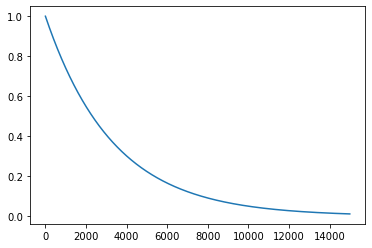

In [5]:
def epsilon_greed_strategy():
    epsilon = []
    maximum = 1.0
    minimum = 0.001

    # number of episodes for training : 15,000
    episodes = np.arange(0, 15000)

    for i in episodes:
        epsilon.append(minimum +
                       (maximum - minimum) * np.exp(-0.0003 * i))

    plt.plot(episodes, epsilon)
    plt.show()
    
epsilon_greed_strategy()

#### DQN Agent Class

input : encoded state i.e. each vector is a combination of locations + hours in a day + days in a week

output : q-values for all actions

#### Hyperparameters

state_size : 24 + 7 +5 

action_size : length of q values

learning_rate : learning rate for finding the global minima

nn_epochs : number of epochs for neural network

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.09, gamma=0.95, batch_size=32,memory_length=2000, nn_epochs=1):
        """
        Constructor to initialize hyperparameter, getting env class, build model and create directory for storing model
        """
        self.set_hyperparameters(state_size, action_size, learning_rate, gamma, batch_size, memory_length, nn_epochs)
        # environment object
        self.cab_environment = CabDriverEnvironment()
        # create main and target model
        self.model = self.build_model()
        # create a model directory
        self.create_model_dir()

    def set_hyperparameters(self, state_size, action_size, learning_rate,
                            gamma, batch_size, memory_length, nn_epochs):
        self.state_size = state_size
        self.action_size = action_size

        # define hyperparameters to be used for training the model
        self.hyperparameters = {
            'learning_rate': learning_rate,
            'gamma': gamma,
            'batch_size': batch_size,
            'memory_length': memory_length,
            'nn_epochs': nn_epochs
        }

        # replay memory for DQN
        self.replay_memory = collections.deque(maxlen=self.hyperparameters['memory_length'])

    def create_model_dir(self):
        lrate = self.hyperparameters['learning_rate']
        gamma = self.hyperparameters['gamma']
        bsize = self.hyperparameters['batch_size']
        
        self.model_dir = 'Cab_model_lrate_{0}_gamma_{1}_batch_{2}'.format(lrate, gamma, bsize)

        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)

    def build_model(self):
        """ 
        Build neural network model with input dimension of state size
        """
        model = Sequential()
        # This is input layer with state size
        model.add(Dense(32,input_dim=self.state_size,activation='relu',kernel_initializer='he_uniform'))
        # Adding hidden layer
        model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
        # Output layer willhave action size
        model.add(Dense(self.action_size, activation='relu',kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.hyperparameters['learning_rate']))
        model.summary()
        return model

    def get_action(self, state, episode):
        """ 
        Choose an action for a given state and episode based on
        Epsilon-Greedy strategy. Use both exploration and exploitation
        """
        epsilon_min = 0.0009
        epsilon_max = 1.0
        
        # calculate decay factor for a given episode
        epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-0.0003 * episode)

        random_value = np.random.random()
        
        # fetch possible requests and their index for a given location
        # number of requests per location are calculated based on a poisson distribution
        possible_requests_index, possible_requests = self.cab_environment.get_requests_per_location(state)
        
        if random_value > epsilon:
            # exploitation
            
            # predict q-values of all possible actions for a given state
            encoded_state = self.cab_environment.state_to_vec(state)
            predicted_q_values = self.model.predict(encoded_state)
            
            # filter q-values corresponding to selected requests for a given location
            filter_q_values = [predicted_q_values[0][i] for i in possible_requests_index]
            
            # select index of an action corresponding to max Q-value
            index_max_q_value = np.argmax(np.array(filter_q_values))

            # select request with maximum q-value
            selected_action = possible_requests[index_max_q_value]

        else:
            # exploration

            # select a random request from possible request space
            selected_action = random.choice(possible_requests)
            
        return selected_action

    def append_sample(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))

    def train_model(self):
        """ Pick samples randomly from replay memory (with batch_size) and train the network
        """
        # start training only when the number of samples in memory > batch size
        if len(self.replay_memory) > self.hyperparameters['batch_size']:
            
            batch_size = self.hyperparameters['batch_size']

            # Sample batch from the memory
            mini_batch = random.sample(self.replay_memory, batch_size)

            # initialize input state vector S
            encoded_state_input = np.zeros((batch_size, self.state_size))

            # initialize input state vector S'
            encoded_next_state_input = np.zeros((batch_size, self.state_size))

            action_list, reward_list = [], []

            # for each element in the mini-batch, update input vectors
            # with encoded state values
            for i in range(batch_size):
                state, action, reward, next_state = mini_batch[i]

                encoded_state = self.cab_environment.state_to_vec(state)
                encoded_state_input[i] = encoded_state

                encoded_next_state = self.cab_environment.state_to_vec(
                    next_state)
                encoded_next_state_input[i] = encoded_next_state

                action_list.append(action)
                reward_list.append(reward)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input
            
            # generate Q(s, a)
            current_state_q_values = self.model.predict(encoded_state_input)
            
            # generate Q(s', a)
            next_state_q_values = self.model.predict(encoded_next_state_input)
            
            # for each element in the batch, update respective q-values using the
            # predicted and target q-values
            for i in range(batch_size):
                # each memory element is of form (s, a, s', r)
                # output of NN for a given state generates q-values for all possible actions
                # hence q-value update must be made to only that action 'a' 
                # out of all possible actions in the output

                # given an action 'a', find the corresponding action index
                performed_action = list(
                    filter(
                        lambda x: self.cab_environment.action[x] == action_list[i],
                        range(0, len(self.cab_environment.action))))[0]
                
                # update q-value using formula (r + max Q(s',a))
                current_state_q_values[i][performed_action] = reward_list[i] + (self.hyperparameters['gamma'] * np.max(next_state_q_values))
                
            # train the model with update Q-values
            self.model.fit(encoded_state_input,
                           current_state_q_values,
                           batch_size=batch_size,
                           epochs=self.hyperparameters['nn_epochs'],
                           verbose=0)

    def save(self):
        f_name = self.model_dir + "/" + "dqn_model_" + datetime.now().strftime("%Y%m%d_%H%M%S")
        save_obj(self.model, f_name)

In [7]:
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(1, 0, 0): defaultdict(None, {(1, 2): []}),
             (1, 1, 1): defaultdict(None, {(4, 5): []}),
             (2, 2, 2): defaultdict(None, {(1, 3): [], (3, 4): []}),
             (3, 3, 3): defaultdict(None, {(3, 2): [], (4, 5): []}),
             (4, 4, 4): defaultdict(None, {(4, 1): [], (2, 1): []}),
             (5, 5, 5): defaultdict(None, {(1, 2): [], (2, 3): []})})

#### Configuration Initialization for runing model

In [8]:
total_episodes = 10000

checkpoint_print_episodes = 100

month_end_cost_time = 30 * 24

training_total_rewards_distribution = []
training_total_ride_time_distribution = []
training_total_time_step_distribution = []

#### Initialize DQN Agent

In [9]:
driver_A = DQNAgent(state_size=36,
                    action_size=21,
                    learning_rate=0.01,
                    gamma=0.85,
                    batch_size=32,
                    memory_length=2000,
                    nn_epochs=3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


In [10]:
def train_agent(driver):
    start_time = time.time()

    for episode in range(total_episodes):
        # reset driver state at the beginning of each episode
        current_state = driver.cab_environment.set_inital_state()

        # reset temporary tracking variables
        has_reached_terminal_state = False
        total_ride_time_per_episode = 0
        total_rewards_per_episode = 0
        time_step_per_episode = 0

        while not has_reached_terminal_state:

            # get the current action based on epsilon-greedy strategy
            current_action = driver.get_action(current_state, episode)

            # given the current state and action, calculate next state, reward and ride time
            next_state, total_rewards, total_ride_time = driver.cab_environment.get_next_state(
                current_state, current_action)

            total_ride_time_per_episode += total_ride_time
            total_rewards_per_episode += total_rewards

            if total_ride_time_per_episode >= month_end_cost_time:
                has_reached_terminal_state = True

            # append current experience to replay buffer
            driver.append_sample(current_state, current_action, total_rewards, next_state)

            # train the model
            driver.train_model()

            current_state = next_state
            time_step_per_episode += 1

        training_total_rewards_distribution.append(total_rewards_per_episode)
        training_total_ride_time_distribution.append(total_ride_time_per_episode)
        training_total_time_step_distribution.append(time_step_per_episode)
        update_tracking_states(driver)
        
        if (episode + 1) % checkpoint_print_episodes == 0:
            print(
                "Episode : %d, Avg Monthly Reward : %f, Avg Ride Time : %f, Avg Per Episode Time Step : %f"
                % (episode + 1,
                   np.mean(training_total_rewards_distribution),
                   np.mean(training_total_ride_time_distribution),
                   np.mean(training_total_time_step_distribution)))

    elapsed_time = time.time() - start_time
    print("Elapsed time :", elapsed_time)

In [11]:
train_agent(driver_A)

Episode : 100, Avg Monthly Reward : -141.210000, Avg Ride Time : 723.780000, Avg Per Episode Time Step : 140.510000
Episode : 200, Avg Monthly Reward : -139.910000, Avg Ride Time : 723.925000, Avg Per Episode Time Step : 141.130000
Episode : 300, Avg Monthly Reward : -123.173333, Avg Ride Time : 723.736667, Avg Per Episode Time Step : 141.306667
Episode : 400, Avg Monthly Reward : -105.010000, Avg Ride Time : 723.627500, Avg Per Episode Time Step : 141.417500
Episode : 500, Avg Monthly Reward : -94.942000, Avg Ride Time : 723.530000, Avg Per Episode Time Step : 141.518000
Episode : 600, Avg Monthly Reward : -84.958333, Avg Ride Time : 723.596667, Avg Per Episode Time Step : 141.831667
Episode : 700, Avg Monthly Reward : -69.627143, Avg Ride Time : 723.585714, Avg Per Episode Time Step : 142.261429
Episode : 800, Avg Monthly Reward : -58.985000, Avg Ride Time : 723.546250, Avg Per Episode Time Step : 142.380000
Episode : 900, Avg Monthly Reward : -48.086667, Avg Ride Time : 723.553333, 

Episode : 7200, Avg Monthly Reward : 360.079167, Avg Ride Time : 723.522917, Avg Per Episode Time Step : 155.551250
Episode : 7300, Avg Monthly Reward : 362.484247, Avg Ride Time : 723.524795, Avg Per Episode Time Step : 155.728493
Episode : 7400, Avg Monthly Reward : 365.290000, Avg Ride Time : 723.515946, Avg Per Episode Time Step : 155.933514
Episode : 7500, Avg Monthly Reward : 367.850800, Avg Ride Time : 723.511600, Avg Per Episode Time Step : 156.129733
Episode : 7600, Avg Monthly Reward : 370.118289, Avg Ride Time : 723.505658, Avg Per Episode Time Step : 156.323816
Episode : 7700, Avg Monthly Reward : 372.270000, Avg Ride Time : 723.506104, Avg Per Episode Time Step : 156.493896
Episode : 7800, Avg Monthly Reward : 373.664231, Avg Ride Time : 723.503462, Avg Per Episode Time Step : 156.649231
Episode : 7900, Avg Monthly Reward : 375.837722, Avg Ride Time : 723.497468, Avg Per Episode Time Step : 156.866835
Episode : 8000, Avg Monthly Reward : 378.594750, Avg Ride Time : 723.496

#### Save model pb file

In [16]:
driver_A.model.save("C:\\model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\model\assets


###### We are getting error can't pickle _thread.RLock objects and hence we are saving weights of model in pkl file

In [18]:
weigh= driver_A.model.get_weights();    
pklfile= "C:\\model\\modelweights.pkl"

fpkl= open(pklfile, 'wb')    #Python 3     
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

#### Print state action number of Q tracked values

In [19]:
for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))

state - (1, 0, 0) - action - (1, 2) - 10000
state - (1, 1, 1) - action - (4, 5) - 0
state - (2, 2, 2) - action - (1, 3) - 10000
state - (2, 2, 2) - action - (3, 4) - 1
state - (3, 3, 3) - action - (3, 2) - 0
state - (3, 3, 3) - action - (4, 5) - 0
state - (4, 4, 4) - action - (4, 1) - 10000
state - (4, 4, 4) - action - (2, 1) - 10000
state - (5, 5, 5) - action - (1, 2) - 10000
state - (5, 5, 5) - action - (2, 3) - 10000


#### Initialize few tracking states from above

In [26]:
tracked_states_plotting = [((1, 0, 0), (1, 2)),
                           ((2, 2, 2), (1, 3)),
                           ((4, 4, 4), (4, 1)), 
                           ((5, 5, 5), (2, 3))]

#### Helper functions to plot Q values over state and action

In [27]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [28]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

#### Plot Q Value convergence over state and action

<Figure size 1440x1080 with 0 Axes>

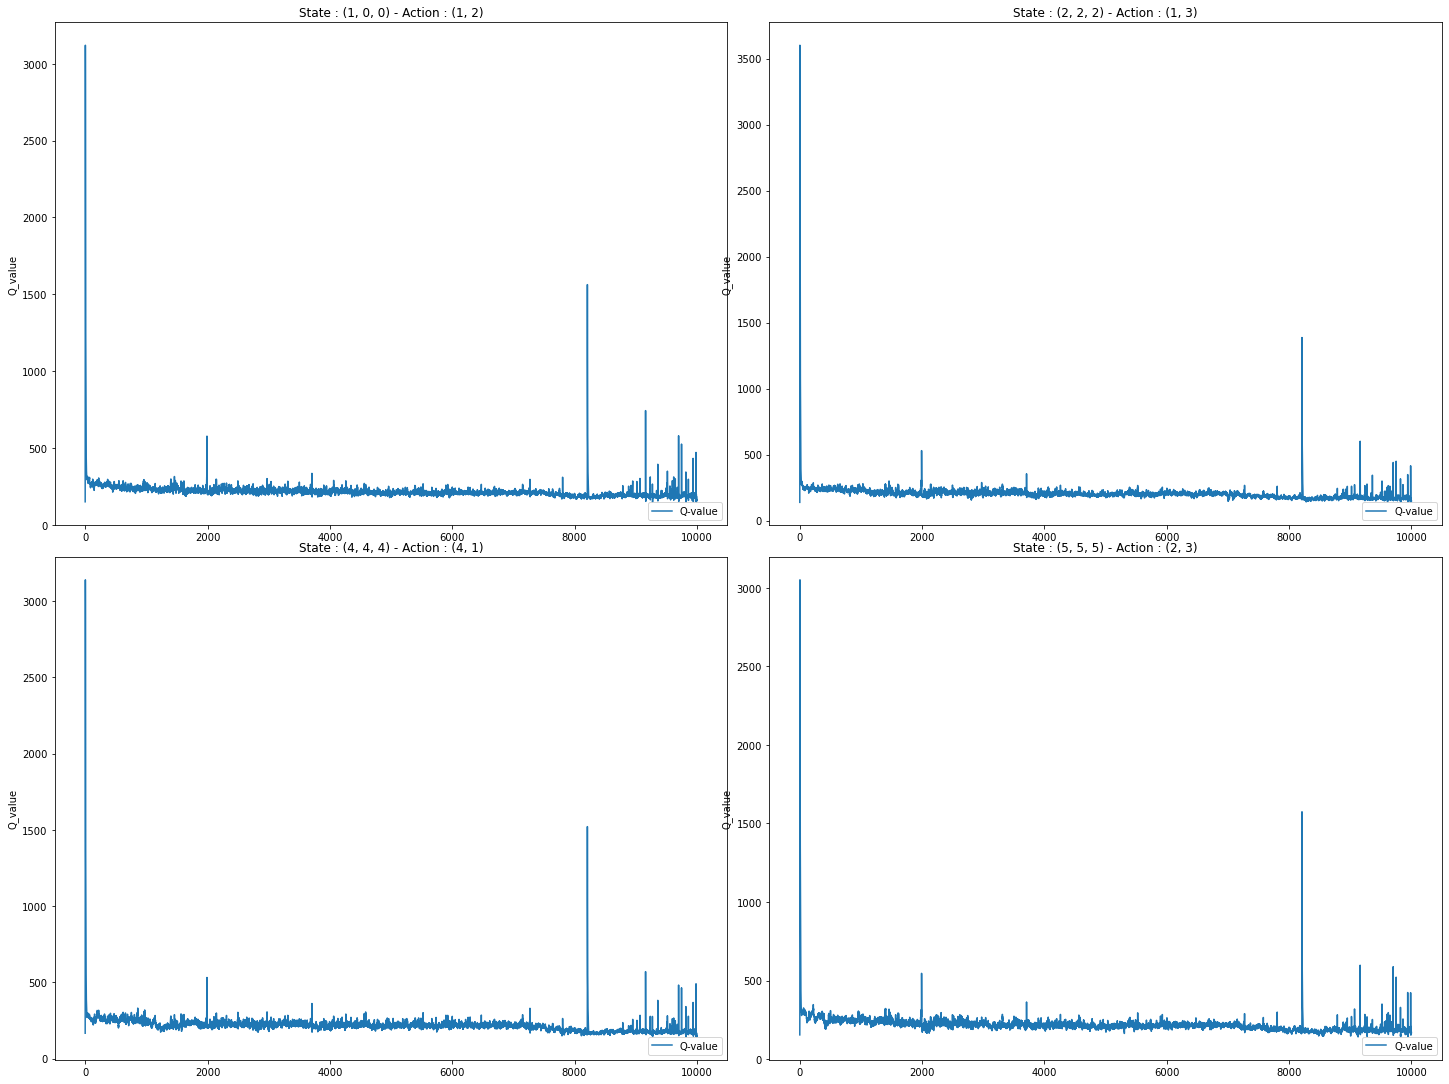

In [29]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i +=1

plt.show()

#### Log Values for Q over state and Action

<Figure size 1440x1080 with 0 Axes>

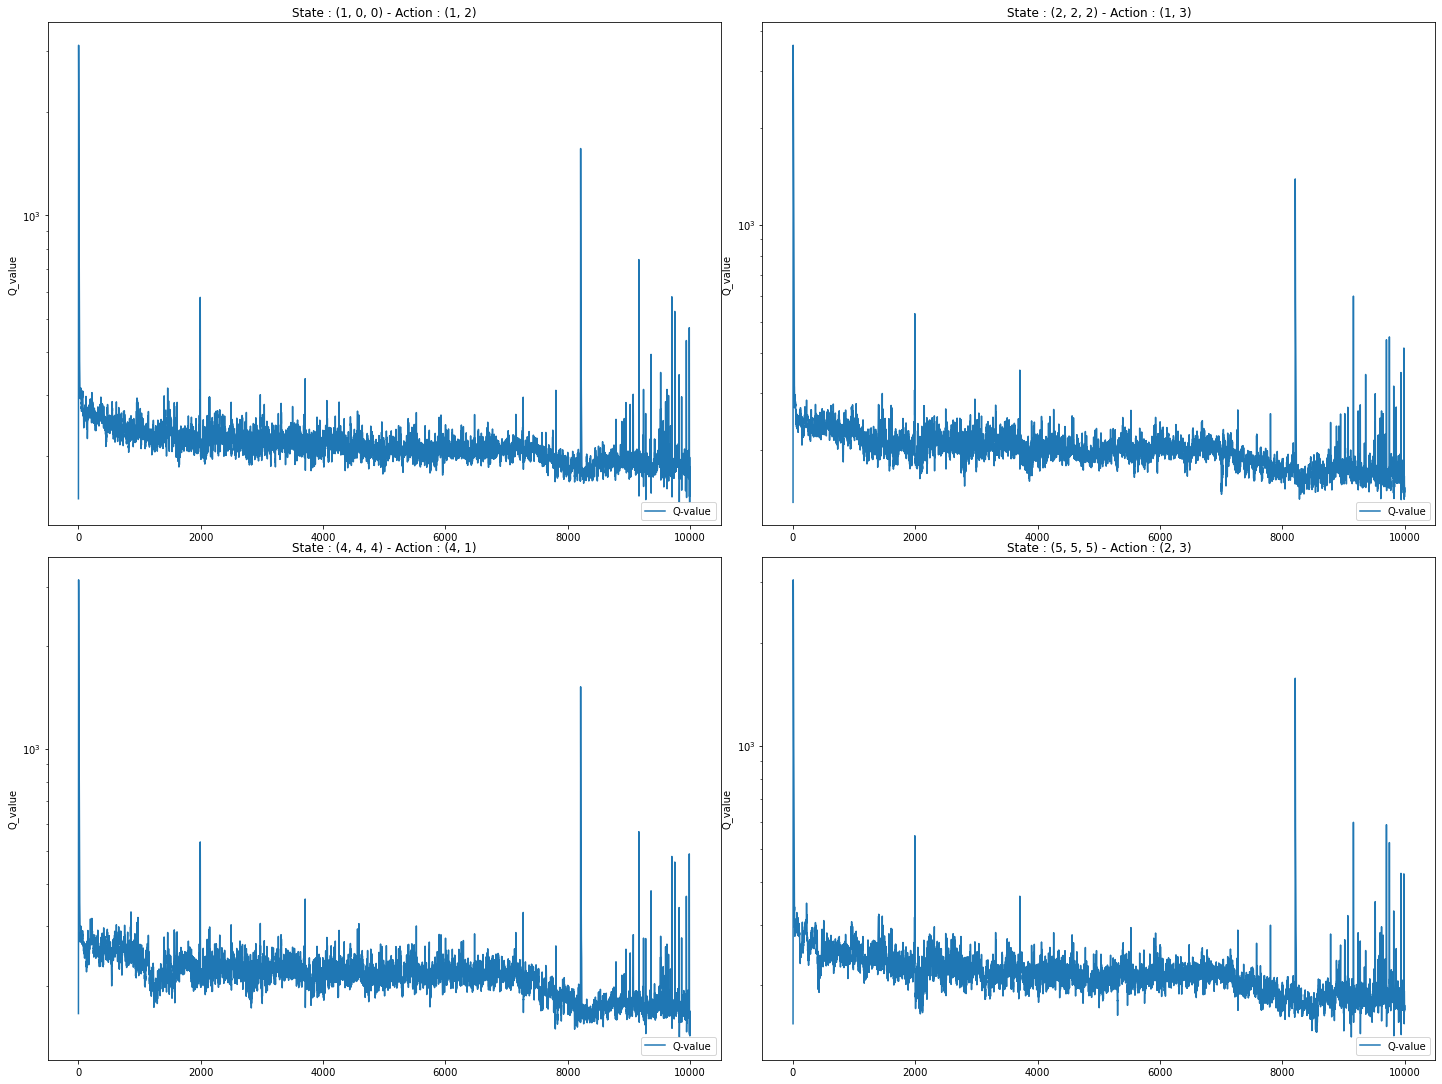

In [30]:

plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        plot_q_val_log_convergence(state, action)
        i +=1

plt.show()

#### Episode VS Rewards

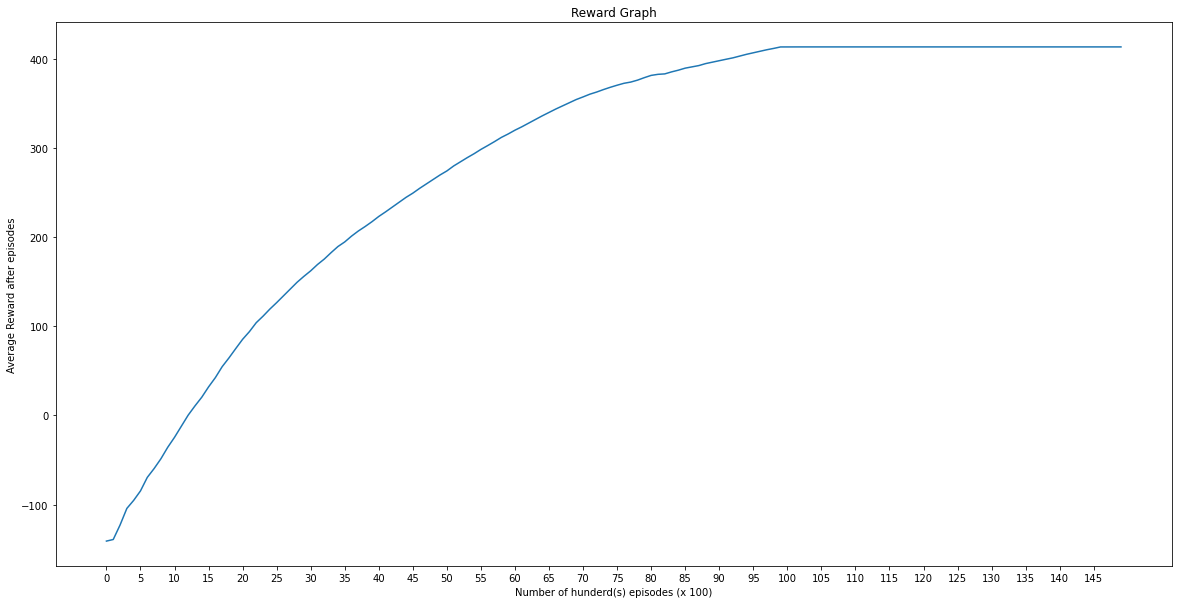

In [31]:
avg_monthly_rewards = [
    np.mean(training_total_rewards_distribution[0:x + 99])
    for x in range(0, 15000, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hunderd(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()